In [15]:
import re
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from typing import List
from collections import namedtuple
from enum import Enum
import zipfile
import zlib
import drawsvg as dw
from drawsvg import FrameAnimation

In [3]:
BASE_DIR = "base/LIBRARY/PonyTemplate►/PonyTemplate►BodyParts/PonyTemplate►Wings/"

In [4]:
class DrawCommand(Enum):
    MOVETO = 0
    LINETO = 1
    QUADRATICTO = 2
Edge = namedtuple("Edge", ["type", "data", "S"])
Path = namedtuple("Path", ["edges", "stroke", "fill0", "fill1"])
Shape = namedtuple("Shape", ["palette","transformation_pt", "paths"])
Point = namedtuple("Point", ["x", "y"])

def xml_find_prepend(root: Element, path: List[str]):
    return root.find("/".join(".//{http://ns.adobe.com/xfl/2008/}"+p for p in path))
def xml_findall_prepend(root: Element, path: List[str]):
    return root.findall("/".join(".//{http://ns.adobe.com/xfl/2008/}"+p for p in path))
SYMBOLS = [
    r"\s*\!(-*\d+\.*\d*)\s+(-*\d+\.*\d*)\s*",
    r"\s*\|(-*\d+\.*\d*)\s+(-*\d+\.*\d*)\s*",
    r"\s*\[((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s+((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s+((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s+((?:\#[0-9A-F]{1,6}\.[0-9A-F]{1,2})|(?:-*\d+\.*\d*))\s*",
    r"S\d{1}"
]

def decode_fla_value(val: str):
    if val[0]=="#":
        hex_out = "".join(val[1:].split("."))
        out = int(hex_out, 16)
        if out >= 0x80000000:
            out = -(0xffffffff - out + 1)
        out = out / (256 if len(val.split(".")[1])==2 else 16)
    else:
        out = float(val) if "." in val else int(val)
    if (out>100000): print(val, out)
    return out

def pathstring_parse(pathstr: str, S: int):
    c = 0
    code = []
    edge = pathstr
    prev_pos = None
    while c<len(edge):
        found_symbol = False
        for i in range(len(SYMBOLS)):
            out = re.match(SYMBOLS[i], edge[c:])
            if (out!=None):
                found_symbol = True
                if i!=3:
                    args = [decode_fla_value(c) for c in out.groups()]
                    if prev_pos!=args[-2:] or i!=0:
                        code.append(Edge(DrawCommand(i), args, S))
                    prev_pos = args[-2:]
                else:
                    S = int(out.group(0)[1])
                c+=out.span()[1]-out.span()[0]
                break
        if not found_symbol:
            print(edge[c:c+50])
            break
    return S, code

def DOMshape_parse(elm: Element):
    trans_pt_node = xml_find_prepend(element, ["transformationPoint"])
    trans_pt = xml_find_prepend(trans_pt_node, ["Point"]) if trans_pt_node!=None else None
    trans_coords = Point(trans_pt.attrib['x'], trans_pt.attrib['y']) if trans_pt!=None else (-1, -1)
    # color palette
    fills = xml_findall_prepend(elm, ["fills/"])
    fill_dict = {0: None}
    for fill in fills:
        fill_dict[fill.attrib["index"]] = xml_find_prepend(fill, ["SolidColor"]).attrib["color"]

    # paths
    edges = xml_findall_prepend(elm, ["edges/"])
    paths = []
    hints = [] # not using hints cubics for now
    S = 0
    for edge in edges:
        if "edges" in edge.attrib:
            fill0 = fill_dict[edge.attrib["fillStyle0"] if "fillStyle0" in edge.attrib else 0]
            fill1 = fill_dict[edge.attrib["fillStyle1"] if "fillStyle1" in edge.attrib else 0]
            S, temp = pathstring_parse(edge.attrib["edges"].replace("\n", "").strip(), S)
            paths.append(Path(temp, stroke_col, fill0, fill1))
        else:
            hints.append(edge.attrib["cubics"])
    return Shape(fill_dict, trans_coords, paths)

root  = ET.parse(BASE_DIR+"PonyTemplate►3Q Front Wing.xml").getroot()
layers = xml_find_prepend(root, ["timeline", "DOMTimeline", "layers"])
animations = []
for layer in layers:
    stroke_col = layer.attrib["color"]
    frames = xml_findall_prepend(layer, ["frames/"])
    anim_frames = []
    for frame in frames:
        shapes = []
        elements = xml_findall_prepend(frame, ["elements/"])
        for element in elements:
            if element.tag=="{http://ns.adobe.com/xfl/2008/}DOMShape":
                shapes.append(DOMshape_parse(element))
            if element.tag=="{http://ns.adobe.com/xfl/2008/}DOMGroup":
                for member in xml_findall_prepend(element, ["members/"]):
                    shapes.append(DOMshape_parse(element))
        anim_frames.append(shapes)

    animations.append(anim_frames)

In [184]:
def get_startpt(path: Path):
    return path.edges[0].data
def get_endpt(path: Path):
    if path.edges[-1].type == DrawCommand.QUADRATICTO:
        return path.edges[-1].data[2:]
    else:
        return path.edges[-1].data
def closed(path: Path):
    return get_startpt(path)==get_endpt(path)
def get_pt(edge):
    if edge.type == DrawCommand.MOVETO:
        return edge.data
    if edge.type == DrawCommand.LINETO:
        return edge.data
    if edge.type == DrawCommand.QUADRATICTO:
        return edge.data[2:]
def get_quad(edge):
    if edge.type == DrawCommand.MOVETO:
        return None
    if edge.type == DrawCommand.LINETO:
        return None
    if edge.type == DrawCommand.QUADRATICTO:
        return edge.data[:2]
def path_join(path1: Path, path2: Path):
    if get_endpt(path1)==get_startpt(path2):
        return Path(path1.edges+path2.edges[1:], path1.stroke, path1.fill0, path1.fill1)
    else:
        return None

def reverse_draw_commands(path: Path):
    edges = path.edges
    reversed_edges = [Edge(DrawCommand.MOVETO, get_pt(edges[-1]), edges[-1].S)]
    prev_quad = None
    prev_command = None
    endpt = get_pt(edges[-1])
    for edge in reversed(edges):
        endpt = get_pt(edge)
        if prev_command == DrawCommand.MOVETO:
            reversed_edges.append(Edge(DrawCommand.MOVETO, endpt, edge.S))
        elif prev_command == DrawCommand.LINETO:
            reversed_edges.append(Edge(DrawCommand.LINETO, endpt, edge.S))
        elif prev_command == DrawCommand.QUADRATICTO:
            reversed_edges.append(Edge(DrawCommand.QUADRATICTO, prev_quad+endpt, edge.S))
        prev_command = edge.type
        prev_quad = get_quad(edge)
    return Path(reversed_edges, path.stroke, path.fill1, path.fill0)


In [207]:
def addEdgeToGroup(edgeGroups,group,edge):
    if not group in edgeGroups: edgeGroups[group] = []
    edgeGroups[group].append(edge)
def findConnectedTo(prevEdge,edges):
    for i, edge in enumerate(edges):
        if get_startpt(edge) == get_endpt(prevEdge): return i  
    return -1

def findContour(group: List[Path]):
    contour = group.pop(0)
    at = findConnectedTo(contour,group)
    while (not closed(contour) and len(group) > 0 and at!=-1):
        contour = path_join(contour, group[at])
        group.pop(at)
        at = findConnectedTo(contour,group)
    return contour
def findContours(group):
    group = [path for path in group]
    contours = []
    while len(group) > 0:
        contours.append(findContour(group))
    return contours

In [230]:
filledRegs

{'#666666': [Path(edges=[Edge(type=<DrawCommand.MOVETO: 0>, data=[149, 2832], S=0), Edge(type=<DrawCommand.LINETO: 1>, data=[-375, 3144], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-413, 3108, -442, 3086], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-464, 3069, -513, 3056], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-581, 3038, -582, 3038], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-341, 2884, -144, 2804], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[-6, 2749, 66, 2743], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[109, 2740, 135, 2772], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[148, 2789, 148, 2804], S=0), Edge(type=<DrawCommand.LINETO: 1>, data=[149, 2832], S=0), Edge(type=<DrawCommand.MOVETO: 0>, data=[207, 2842], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[303, 2790, 399, 2766], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[507, 2737, 533, 2770], S=0), Edge(type=<DrawCommand.QUADRATICTO: 2>, data=[557, 2801, 

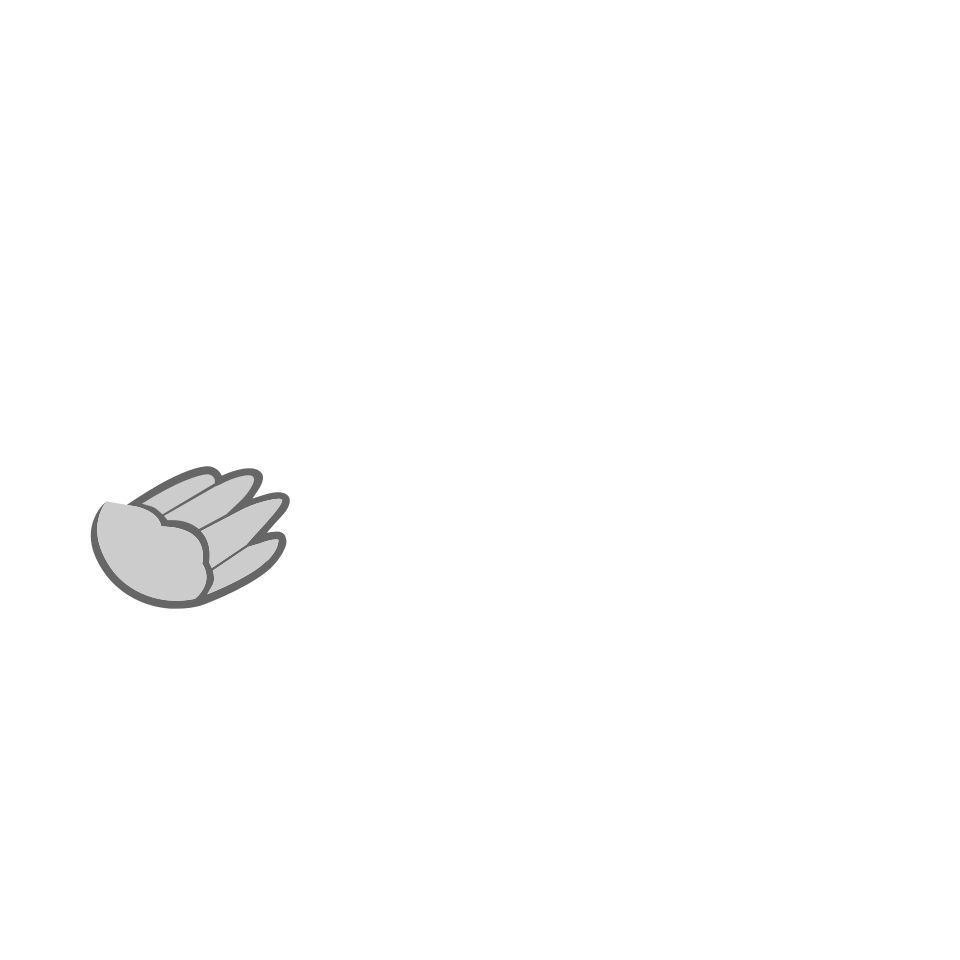

In [231]:
edgeGroups = {}
for path in animations[0][3][0].paths:
    if path.fill0 != None: addEdgeToGroup(edgeGroups, path.fill0,  path)
    if path.fill1 != None: addEdgeToGroup(edgeGroups, path.fill1, reverse_draw_commands(path))
filledRegs = {}
for fillStyle, group in edgeGroups.items():
    filledRegs[fillStyle] = findContours(group)
SCALE = 0.1
OFFSET = 200
d = dw.Drawing(960, 960, id_prefix='pic')
for fillCol, contours in filledRegs.items():
    for contour in contours:
        tracer = dw.Path(fill=fillCol, stroke_width=0)
        tracer.M(OFFSET+contour.edges[0].data[0]*SCALE, OFFSET+contour.edges[0].data[1]*SCALE)
        for edge in contour.edges:
            if edge.type==DrawCommand.MOVETO:
                tracer.M(OFFSET+edge.data[0]*SCALE, OFFSET+edge.data[1]*SCALE)
            if edge.type==DrawCommand.LINETO:
                tracer.L(OFFSET+edge.data[0]*SCALE, OFFSET+edge.data[1]*SCALE)
            if edge.type==DrawCommand.QUADRATICTO:
                tracer.Q(OFFSET+edge.data[0]*SCALE, OFFSET+edge.data[1]*SCALE, OFFSET+edge.data[2]*SCALE, OFFSET+edge.data[3]*SCALE)
        tracer.Z()
        d.append(tracer)
d


In [7]:
tag_names = set()
def traverse(element):
    if 'color' in element.attrib and element.tag=='{http://ns.adobe.com/xfl/2008/}SolidColor':
        tag_names.add(element.attrib['color'])
    for child in element:
        traverse(child)
traverse(root)
tag_names

{'#00FF00', '#666666', '#CCCCCC'}

In [13]:
tag_names = set()
def traverse(element):
    tag_names.add(element.tag)
    for child in element:
        traverse(child)
traverse(root)
tag_names

{'{http://ns.adobe.com/xfl/2008/}DOMFrame',
 '{http://ns.adobe.com/xfl/2008/}DOMGroup',
 '{http://ns.adobe.com/xfl/2008/}DOMLayer',
 '{http://ns.adobe.com/xfl/2008/}DOMShape',
 '{http://ns.adobe.com/xfl/2008/}DOMSymbolItem',
 '{http://ns.adobe.com/xfl/2008/}DOMTimeline',
 '{http://ns.adobe.com/xfl/2008/}Edge',
 '{http://ns.adobe.com/xfl/2008/}FillStyle',
 '{http://ns.adobe.com/xfl/2008/}Matrix',
 '{http://ns.adobe.com/xfl/2008/}Point',
 '{http://ns.adobe.com/xfl/2008/}SolidColor',
 '{http://ns.adobe.com/xfl/2008/}edges',
 '{http://ns.adobe.com/xfl/2008/}elements',
 '{http://ns.adobe.com/xfl/2008/}fills',
 '{http://ns.adobe.com/xfl/2008/}frames',
 '{http://ns.adobe.com/xfl/2008/}layers',
 '{http://ns.adobe.com/xfl/2008/}matrix',
 '{http://ns.adobe.com/xfl/2008/}members',
 '{http://ns.adobe.com/xfl/2008/}timeline',
 '{http://ns.adobe.com/xfl/2008/}transformationPoint'}

In [ ]:
# 6DABDC - rd outline
# 9EDBF8 - rd fill

In [ ]:
	"moveTo(x,y)"
"|x y"			"lineTo(x,y)"
"!x y"		"[cx cy x y"	"quadraticTo(cx,cy,x,y)"